# Lecture 4. Classification and Regression Trees. Random Forests

by Nadzeya Laurentsyeva @ nadzeya.laurentsyeva@econ.lmu.de


In [1]:
# Packages to import 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn import tree as tree


## Back to Supervised Learning Methods 


<img src="figures/MLtypes1.png" style="height:350px">


Source: https://towardsdatascience.com/machine-learning-types-2-c1291d4f04b1

# 1. Introduction 

##  Motivating example


### Consider the following data-generation process: 

$y = -0.5x + 100 + \epsilon$ if x <= -10;

$y = -15 + \epsilon$ if -10<x<=100; 

$y = 42 + 0.5x + \epsilon$ if x>100;

where $E(\epsilon) = 0$ and $Var(\epsilon)$ = $\sigma^2$


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'e'}>]], dtype=object)

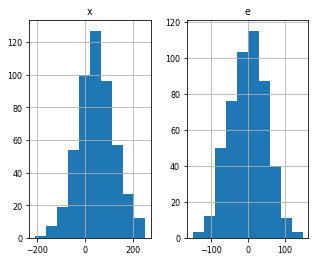

In [18]:
# we start by randomly generating our X's

np.random.seed(15) # set the seed for replications

df = pd.DataFrame(data = np.random.normal(50, 75, (500, 1)), columns = ['x']) #mean, standard deviation, size of data: (rows, columns)
df['e'] = np.random.normal(0, 50,(500, 1))


# setting parameters for figures in this notebook, can be also set individual in each graph 
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (5, 4)}) 

# histogram of generated variables
df.hist()


In [19]:
# we define conditions to generate Y's
conditions = [
    (df['x'] <= -10),
    ((df['x']>-10) & (df['x'] <= 100)),
    (df['x']>100),
    ]
# create a list of the values we want to assign for each condition
values = [-0.5*df['x']+100, -15, 42+0.5*df['x']]

# create a new column and use np.select to assign values to it using our lists as arguments
df['y'] = np.select(conditions, values)
df['y'] = df['y'] + df['e']
df.describe()

,x,e,y
count,500.000000,500.000000,500.000000
mean,47.659901,-1.501136,47.264446
std,75.665494,49.417127,83.671983
min,-209.969479,-151.155001,-137.798886
25%,-4.079899,-38.564987,-14.784411
50%,43.771165,0.190587,43.027084
75%,98.637999,33.753859,114.921212
max,250.360818,148.432604,312.669254


<AxesSubplot:xlabel='x', ylabel='y'>

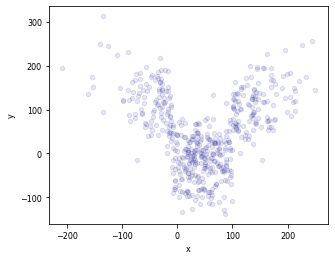

In [11]:
df.plot.scatter(x='x', y='y', c='DarkBlue', alpha = 0.1)

### What if we don't know much about the data generation process, and try to build a prediction model using OLS regression?

**We can start by fitting a quadratic regression** 

We train the model on 80% of our data. We estimate in- and out-of-sample fits and plot the actual and fitted values 
from the test sample. 

In [36]:
# We can add higher orders of x:
pwr = 8 #orders of x that we want to create
for i in range (2,pwr+1):
    df[f"x_{i}"] = np.power(df['x'], i) #note f-string formatting in python https://realpython.com/python-f-strings/ 
df.head()

,x,e,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8
0,26.575364,-80.002840,-95.002840,706.249966,18768.849829,4.987890e+05,1.325550e+07,3.522697e+08,9.361696e+09,2.487905e+11
1,75.446353,26.143834,11.143834,5692.152174,429452.121983,3.240060e+07,2.444507e+09,1.844291e+11,1.391450e+13,1.049799e+15
2,38.306860,83.770274,68.770274,1467.415520,56212.080822,2.153308e+06,8.248648e+07,3.159798e+09,1.210419e+11,4.636737e+12
3,12.365775,-15.658042,-30.658042,152.912379,1890.879998,2.338220e+04,2.891390e+05,3.575427e+06,4.421293e+07,5.467271e+08
4,67.667667,38.738263,23.738263,4578.913141,309844.369089,2.096645e+07,1.418750e+09,9.600353e+10,6.496335e+12,4.395918e+14


In [42]:
# example how to select the controls
df.iloc[:, [0]+list(range(3, 6))] 

,x,x_2,x_3,x_4
0,26.575364,706.249966,18768.849829,4.987890e+05
1,75.446353,5692.152174,429452.121983,3.240060e+07
2,38.306860,1467.415520,56212.080822,2.153308e+06
3,12.365775,152.912379,1890.879998,2.338220e+04
4,67.667667,4578.913141,309844.369089,2.096645e+07
...,...,...,...,...
495,71.570388,5122.320499,366606.467748,2.623817e+07
496,-14.776317,218.339535,-3226.254116,4.767215e+04
497,-88.085819,7759.111450,-683467.684221,6.020381e+07
498,0.191995,0.036862,0.007077,1.358805e-03


In [43]:
# we fit a simple regression 

y = df['y'] 
X = df.iloc[:, [0]+list(range(3, 6))] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

regr = LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1) # if we use defaults, the option can be skipped
regr.fit(X_train, y_train)

# to see the coefficients
print('Intercept: %.3f' %regr.intercept_)
print('Coefficients: ' )
print(regr.coef_ )

# Make out-of-sample predictions 
y_pred = regr.predict(X_test)
y_pred_in = regr.predict(X_train)

Intercept: 17.254
Coefficients: 
[-1.18153924e+00  1.20357612e-02  3.29480079e-05 -2.20590913e-07]


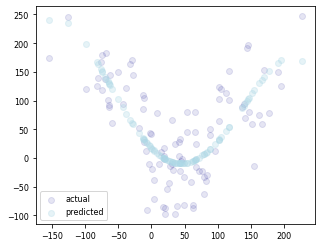

In [44]:
# plot actual values of Y vs predicted against X using the test sample
plt.scatter(X_test['x'], y_test, c='DarkBlue', alpha = 0.1, label='actual')
plt.scatter(X_test['x'], y_pred, c = 'LightBlue', alpha = 0.3, label='predicted')
plt.legend()

In-sample Rsq: 0.382
Out-of-sample Rsq: 0.550


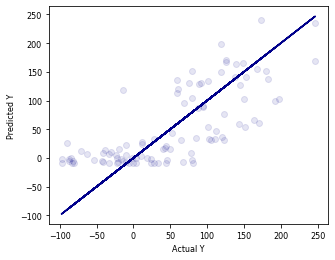

In [45]:
# plot actual values of Y vs predicted
# the line shows 
plt.scatter(y_test, y_pred, c = 'DarkBlue', alpha = 0.1)
plt.plot(y_test, y_test, c = 'DarkBlue')
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')

# In and out-of-sample R-sq. 
print('In-sample Rsq: %.3f'
      % r2_score(y_train, y_pred_in))
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))

### Doesn't look as good, ... we can continue by improving the OLS ... 

* Try out higher-order regressions 
* By observing the data (or from some background knowledge), we can guess that there are discontinuities around x=-10 and x = 100
* What if we have more dimensions? 
* What if there are potential interactions between different dimensions? 
* A parametric model might be too restrictive 

### Or try a fully nonparametric method of Classification and Regression Trees (CART)

We train a CART tree on 80% of our data (we will go through the detail in a while). We again take $y$ as an outcome and $x$ as the only input. The graph below shows the predicted and actual values.

In [50]:
y = df['y'] 
X = df['x'].values.reshape(-1,1) # reshaping is needed if your X is one-dimensional, as otherwise, the array is read in a row, not in a column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15) # in real applications, try to use as much training data as possible - 80%/20% or 90%/10%


cart = tree.DecisionTreeRegressor(min_samples_leaf = 5) #min_samples_leaf = 5 
cart.fit(X_train, y_train)

y_pred_in = cart.predict(X_train)
y_pred = cart.predict(X_test)

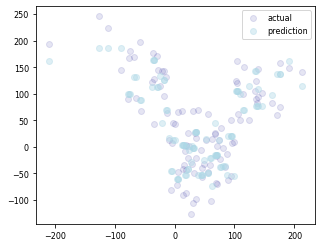

In [51]:
plt.scatter(X_test, y_test, c='DarkBlue', alpha = 0.1, label = 'actual')
plt.scatter(X_test, y_pred, c = 'LightBlue', alpha = 0.4, label= 'prediction')
plt.legend()

In-sample Rsq: 0.761
Out-of-sample Rsq: 0.606


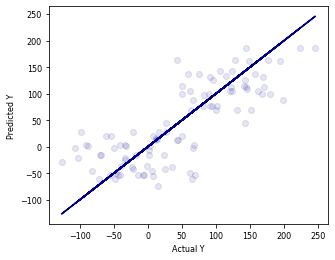

In [52]:
plt.scatter(y_test, y_pred, c = 'DarkBlue', alpha = 0.1)
plt.plot(y_test, y_test, c = 'DarkBlue')
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')

# In and Out-of-sample R-sq.
print('In-sample Rsq: %.3f'
      % r2_score(y_train, y_pred_in))
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))

<div class="alert alert-block alert-info">
<b>Question. </b> 
Why do you think out-of-sample $R^2$ for a decision tree still looks worse than that for OLS? Note the in-sample $R^2$ as well.     
    
Modify 
            _cart = tree.DecisionTreeRegressor()_ 
to 
            _cart = tree.DecisionTreeRegressor(min_samples_leaf = 5)_
    
What has just happened? 


</div>

### This lecture: fully nonparametric method of Classification and Regression Trees (CART)

* Learn about classification and regression trees, how to grow and to tame them
* Compare the predictive performance of this approach to that of OLS and Lasso (more in the Tutorial). 
* Discuss advantages and limitations of this approach 
* This lecture: we focus on the prediction problem
* Next lecture: application to econometrics; estimation of treatment effects 

# 2. Classification and Regression Trees (CART): How to grow a tree


## Parametric vs. Non-parametric methods

||Parametric method, e.g. OLS |Non-parametric method, e.g. CART|
|------|------|------|
|_Modelling_     |Place restrictions (e.g. linear) on how the inputs can influence the response     | Learn the relationship from the data, no assumptions about data generation |
|_Analysis_    |Find the mapping _function_ by optimizing parameters     |Find a logical system (e.g. decision tree) for mapping inputs to outputs    |
|_Strong points_    |Captures many real-life data processes; can achieve stability   | Flexibility |

**To be aware of**: 
* Non-parameteric methods do not perform well for large P/N (P - parameters; N - number of observations). Rule of thumb: $P < N/4$. 
* Non-parametric methods assume _independence_ between observations; if this assumption fails (time-series analysis), parametric models will likely outperform. 

## Trees (1)

Suppose we have an input $x$ and an output $y$ (either qualitative or quantitative).  

A basic decision tree: 

* A logical system for mapping from inputs to outputs 
* Hierarchical: use a series of ordered steps (nodes) to reach a decision 
* Each decision node (parent) contains a split on the available input data 
* The leaf nodes contain the final decision (prediction rule)
    * the predicted $\hat{y}$ - the average of the sample $y$ values that end up in that leaf
* Goal: have the sequence of such decision nodes that combine for a _good_ final choice. 

**Example with one-dimensional $x$**

<img src="figures/nodes.png" style="height:250px">

**Example with two-dimensional $x$**

We split the space of inputs into regions $R_i$ and assign a certain predicted value to each of the regions. 

<img src="figures/bivariate.png" style="height:350px">
Source: Hastie, Tibshirani, Friedman, 2ed 

## Trees (2)

**Goal: have the sequence of such decision nodes that combine for a _good_ final choice.**

At every step (node), we are interested in finding a split that minimizes a loss function $\sim$ distance between our prediction $\hat{y}$ and data $y$. Here: the prediction $\hat{y}$ is defined through splitting via thresholds on dimensions of input $x$ and averaging of the $y$ values that end up in corresponding child nodes. 

Given a parent node with $(x_i, y_i)^n_{i=1}$, the optimal split is location $x_{ij}$ - dimension $j$ on observation $i$ - that makes the child sets as homogeneous in $y$ as possible.

## Trees (3)

* **Regression - our prediction is the average of $y$ values that end up in a child node after a split.** 
    * Loss function: sum-squared error $\sum_{i=1}^n(y_i - \hat{y_i})^2$
    * We want to minimize the function (make the child nodes as homogenous as possible) $\sum_{i\in left}(y_i-\hat{y}_{left})^2 + \sum_{i\in right}(y_i-\hat{y}_{right})^2$  
    
    <br>
    
* **Classification - our prediction is the most commonly occuring class of observations in a child node after a split.** We denote with $\hat{p_{mk}}$ the share of observations in the $m_{th}$ child node that are from class $k$. 

    * Classification error (misclassification rate): $1-max_k(\hat{p}_{mk})$
    
         * Fraction of observations that do not belong to the most common class 
         * ! Not sufficiently sensitive for tree growing 
         
    * Gini impurity (Gini index) : $\sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})$
        * Captures variance across K classes in a node $m$
        * It is small when all $\hat{p}_{mk}$ are close to 0 or 1 $\rightarrow$ the node contains observations mostly from the same class
        * Note: not to be confused with Gini coefficient https://en.wikipedia.org/wiki/Gini_coefficient#Calculation 
        
    * Entropy (information gain) : -$\sum_{k=1}^K\hat{p}_{mk}log(\hat{p}_{mk})$ 
        * Numerically very close to Gini index 
   

## Trees (4)

**CART Algorithm, Breiman et al. (1984)**

We start at the root that contains the full (training) sample. We use _greedy top-down search_. 
For each node:  

1. Determine the single error minimizing split for this data sample (i.e. we try across all dimensions $j$ and all observations $i$)
    * For each dimension $X_j$: 
        * for each potential split point $i$: calculate the prediction and the value of the loss function; choose split point $i$ minimizing the loss function;
    * Choose $X_j$, such that  splitting by this dimension yields the lowest value of the loss function. 
    
2. Split this parent node into the left and right children accordingly 
3. Apply steps 1 and 2 to each child node. 

Continue until a stopping rule applies: 
* Have reached a leaf node of a prespecified minimum size (e.g. 10 observations in each leaf) 
* Have reached the cutoff for the minimum loss improvement
* Use a prespesified maximum depth or a maximum number of nodes.
* ... 

In [64]:
#import matplotlib
#from sklearn import tree as tree

# We now try to fit the tree to our generated data from the 'Motivating Example'

y = df['y'] 
X = df['x'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15) 

# if we don't use a stopping rule, our tree will overfit by picking up too much noize from our training dataset
# try to change the parameters for the stopping rule (min_samples_leaf) and check how the OOS performance changes
# we will look at different stopping rules in details below
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html 

cart = tree.DecisionTreeRegressor(min_samples_leaf = 20, max_depth=2, max_leaf_nodes = 10, random_state = 1)

cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.671
Out-of-sample MSE: 2370.215


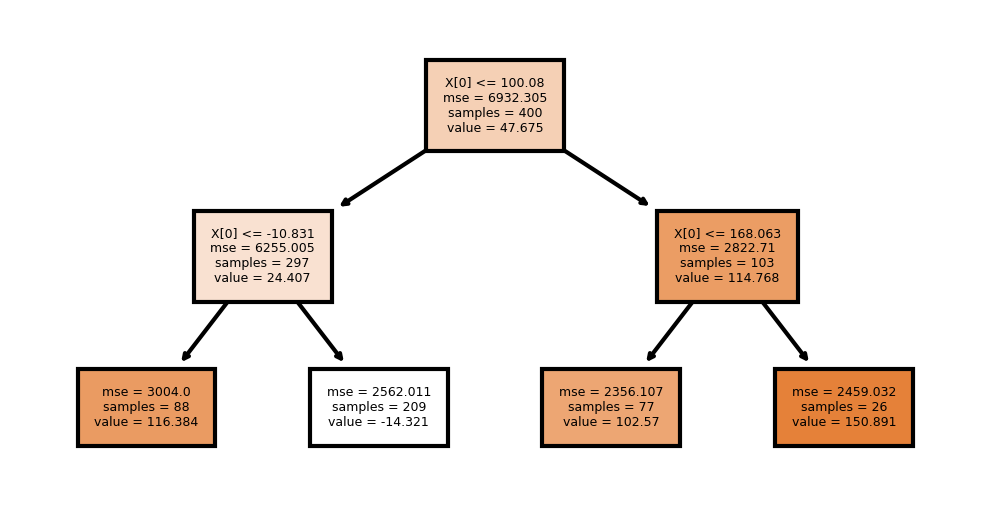

In [65]:
#dendrogram
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True,\
               fontsize = 3);

# 3. Flexiblity vs. Stability: How to Tame a Tree? 

## Pruning a tree

### Example of Prostate Cancer Diagnosis (Taddy 'Business Data Science') 

* We have biopsy data for 97 prostate cancer tumors 
* Aim: build a model to forecast the tumor volume (based on analyses of a patient) and to offer the treatment 
    * lcavol - tumor volume (Y), target
    * age of a patient
    * lbph - size of prostate
    * lcp - reach of tumor into gland lining 
    * gleason -microscopic pattern classes
    * lpsa - protein production 


In [2]:
# source https://github.com/TaddyLab/bds 
df = pd.read_csv("data/prostate.csv", delimiter = ';')
df.head()

,lcavol,age,lbph,lcp,gleason,lpsa
0,-0.579818,50,-1.386294,-1.386294,6,-0.430783
1,-0.994252,58,-1.386294,-1.386294,6,-0.162519
2,-0.510826,74,-1.386294,-1.386294,7,-0.162519
3,-1.203973,58,-1.386294,-1.386294,6,-0.162519
4,0.751416,62,-1.386294,-1.386294,6,0.371564


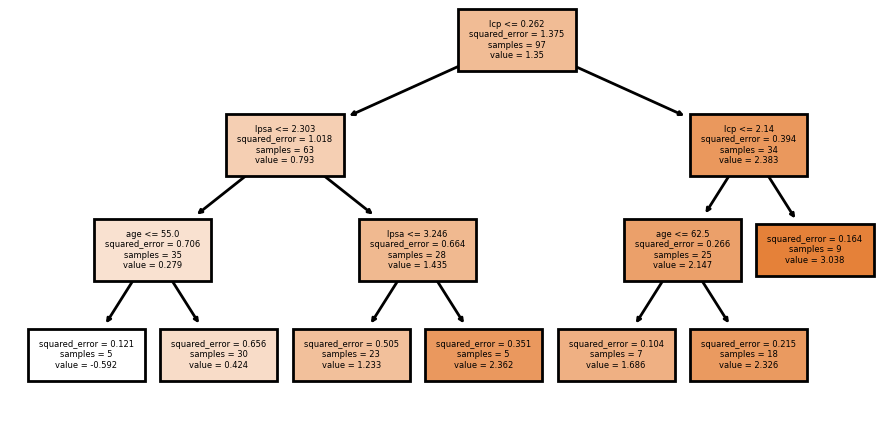

In [19]:
y = df['lcavol'] 
X = df.iloc[:, 1:]

cart = tree.DecisionTreeRegressor(min_samples_leaf = 5,max_depth = 3, max_features = None)
# here I wanted to highlight one more parameter: max_features. It tells how many features (covariates) should be considered at each split. 
# if max_features < n_features, features to consider are selected randomly. 

cart = cart.fit(X, y) #I use all data for prediction here (ideally, I would need to have enough observations to divide my data in training and test samples)

#dendrogram
matplotlib.rcParams.update({'font.size': 14, 'figure.figsize': (2, 1), 'figure.dpi': 200})
tree.plot_tree(cart, max_depth = 10, feature_names = list(X.columns), filled = True,\
               fontsize = 3);



In [20]:
# What is the depth of the tree? 
print(cart.get_depth())

3


In [21]:
# How many leaves does the tree has? 
print(cart.get_n_leaves())

7


### Is this a good forecast model? 

**Advantages of flexibility**
* Identify nonlinear means and interaction effects without us having to specify them in advance 
* Nonconstant variance is not a problem 

<br>

**Drawbacks of flexibility**
* What about overfit? Do we need all the splits or are we fitting much noise? 

### Overview of stopping rules in Sklearn 


* **max_depth**, default=None
    * The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    
* **min_samples_split**, default=2
     * The minimum number of samples required to split an internal node. 

* **min_samples_leaf**, default=1 
    * The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

* **max_leaf_nodes**, default=None
    * Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
    
* **min_impurity_decrease**, default=0.0
    * A node will be split if this split induces a decrease of the impurity greater than or equal to this value.


Which stopping rule shall we choose?  

### Pruning and cross-validation to regularize trees  

* Pruning process: fit a tree (likely to be overgrown) and prune it backward by iteratively removing the leaf splits that yield the lowest in-sample error reduction 
<br>

* We thus obtain a set of candidate trees with a different number of nodes 
<br>

* Choose the best one using cross-validation 

Note: it is also fine to combine several stopping rules (no absolutely strict rules here)

In [72]:
from sklearn.model_selection import cross_validate

# write a function that runs a CV procedure for a candidate model with a given number of leaf nodes (max_leaf_nodes)

def cv_iter(max_leaf_nodes, min_samples_leaf, folds, X, y):
    #define settings for cross validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    #define settings for the regression tree
    cart = tree.DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, random_state = 1)
    #you can use define different scoring parameters 
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    cv_result = cross_val_score(cart, X, y, cv=kf, scoring = 'r2') # would give you Rsq by default
    #note: alternatively you could use cross_validate function, which allows specifying multiple metrics for evaluation.
    #it returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.
    #if you use cross_validate your code would look a bit differently:     
        # cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
        # avg_score = np.mean(cv_result['test_score'])
    avg_score = cv_result.mean()
    return float(avg_score)

In [97]:
y = df['lcavol'] 
X = df.iloc[:, 1:]

result = {}
for i in range(2, 21):
    result[i] = cv_iter(i, 1, 5, X, y) #max_leaf_nodes, min_samples_leaf, folds, X, y

In [96]:
# display dictionary with the results
print(result)

# convert to a dataframe
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results

{2: 0.15815287258493377, 3: 0.36435851151487053, 4: 0.3397190872789363, 5: 0.3169834530885646, 6: 0.3296015170831894, 7: 0.35758871361610983, 8: 0.34480297435532076, 9: 0.3249952647847622, 10: 0.27449804726109356, 11: 0.2817499497066399, 12: 0.2789736366476359, 13: 0.26140589873401165, 14: 0.24592142677734213, 15: 0.20144949510461405, 16: 0.19336589131791532, 17: 0.19051458220875866, 18: 0.14838277522581755, 19: 0.15420514319778258, 20: 0.16931710140622197}


,Test Score
2,0.158153
3,0.364359
4,0.339719
5,0.316983
6,0.329602
7,0.357589
8,0.344803
9,0.324995
10,0.274498
11,0.281750


<AxesSubplot:xlabel='Max leaf nodes'>

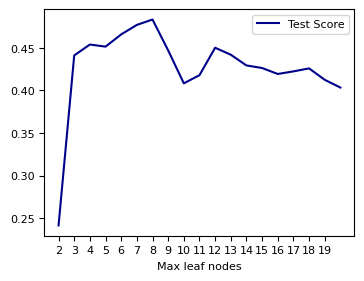

In [94]:
# we can also plot the result
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results.plot(color = 'DarkBlue', xlabel = 'Max leaf nodes', xticks = np.arange(2, len(results['Test Score'])+1, 1))

In [83]:
# find out the number of leaves that generates the highest score
results['Test Score'].idxmax() # max leaf nodes

6

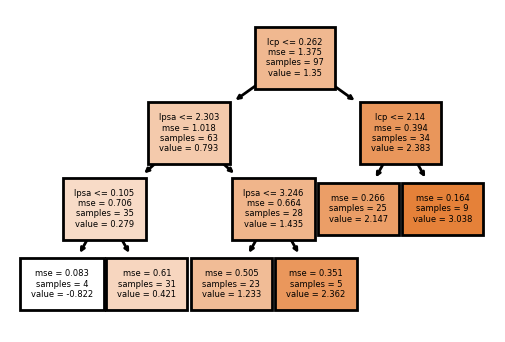

In [84]:
# we refit our model using a tree with the number of  nodes determined by the CV
y = df['lcavol'] 
X = df.iloc[:, 1:]

cart = tree.DecisionTreeRegressor(max_leaf_nodes = results['Test Score'].idxmax())
cart = cart.fit(X, y) 

#dendrogram
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (3, 2), 'figure.dpi': 200})
tree.plot_tree(cart, feature_names = list(X.columns), filled = True,\
               fontsize = 3);


# you can try to experiment and to set a different number of K-folds, different scoring measures
# do you get the same result? 

### Minimal Cost-Complexity Pruning 
It is also possible to do pruning using the Minimal Cost-Complexity Pruning. 
The algorithm finds the subtree of a tree $T$ that minimizes the measure of cost-complexity: 

$R_{alpha}(T) = R(T) + \alpha*N$, 

where $R(T)$ - is the loss function at the terminal nodes (e.g. MSE or misclassification rate). N - number of terminal nodes in a (sub)tree. $\alpha$ is a complexity parameter, which can be tuned by cross-validation. By increasing the number of terminal nodes, we decrease $R(T)$, but at the same time we get a penalty $\alpha * N$ for model complexity. 

Does the idea look familiar to you? 

See the Tutorial for an example. 


# 4. Bootstrap aggregating

**Motivation**: Pruning with cross-validation often does not work well in practice. 
* Highly variable prediction rules
* CV estimates of out-of-sample performance vary across samples 
* High variance in the predictions 

**Solution: Bootstrap aggregating, aka bagging**

Idea: we obtain many trees by fitting CART on _multiple with-replacement_ samples from our data. We then average over this bootstrapped sample of trees. The mean fit across bootstrap samples is an estimate of the average model fit.  

## Random Forest Algorithm (bagging of CART trees)

Suppose B is the bootstrap size (i.e. the number of trees in the forest). For $b = 1 ... B$:

1. Sample with-replacement $n$ observations from the data 
2. Fit a CART tree - $T_b$ - to this sample.

This results in a set of trees $T_1, ... T_B$. The random forest predictions are then the average of individual tree predictions. 

If $\hat{y}_{ib}$ is the prediction given $x_{i}$ from a tree $T_b$, then the random forest prediction is $\hat{y}_{i} = \dfrac{1}{B}\sum_b\hat{y}_{ib}$. 

Why does it work: by averaging over multiple trees, we preserve the stable relationships that persist across bootstrap samples, while the noise averages out. 

_Note:_ in general, model averaging is a common feature in many ML applications $\rightarrow$ ensemble methods. 


### Technicalities 

1. 
_Extra randomization_
If we want to add even more regularization into the model, we can modify Step 2 in the above algorithm. Instead of searching for an optimum split across all dimenstions of $x$, we can let it search across _a random sample_ of inputs (rule of thumb: $\sqrt{p}$ for classification and $p/3$ for regression). In this way, we make sure that the algorithm does not always split variables in a similar order.  

This extra feature does not have a strong theoretical foundation. In practice, it might be useful for small samples (i.e. when $p \sim \sqrt{n}$), but negatively affects performance for large $n$. 

2. _Out-of-bag_ error estimation
A way to estimate the out-of-sample performance of a bagged model without the need for a test sample or a cross-validation procedure. Key: trees are repeatedly fit to bootstrapped subsets of observations. It can be shown, that on average, about two-thirds of the observations are used in each iteration, the remaining are called out-of-bag (OOB) observations. We can do the prediction for an observation $i$ using only those trees, for which this observation was OOB.  


3. 
How many trees to grow in the forest? Grow until the out-of-sample error stabilizes, i.e. adding more trees does not improve the out-of-sample performance of the model. 


4. 
Do you need to use a stopping rule and/or pruning on individual trees while fitting a random forest? 

    * Note, there is no strict suggestion whether we should use a stopping rule and/or pruning for individual trees. Thereoretically, by aggregating over many trees (even if they individually overfit), we will average-out the noise. Thefore, using fully grown trees rarely causes trouble. 

    * However, it also depends on the nature of your data (high  noise vs. low noise, the amount of data and dimensions). For instance, it makes sense to apply a stopping rule if you have a small number of observations and might be more likely to overfit (you can check this with the last example below, where we only have 133 observations). Also when you have a very big dataset, it might make sense to apply a stopping rule, as it will be computationally hard to fit a full tree on your data. 


<AxesSubplot:xlabel='time', ylabel='acceleration'>

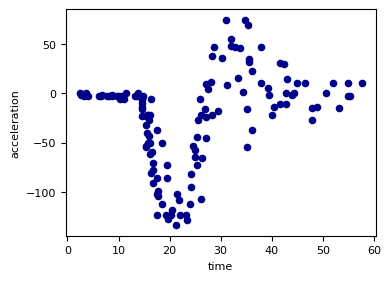

In [98]:
## Illustration with a one-dimensional regression problem 

# https://github.com/TaddyLab/bayesian-forest/blob/master/data/mcycle.csv
# crash-test data of motorcycle helmets; acceleration after collision 

df = pd.read_csv("data/mcycle.csv", delimiter = ';')
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})
df.plot.scatter(x = 'time', y = 'acceleration',c = 'DarkBlue')

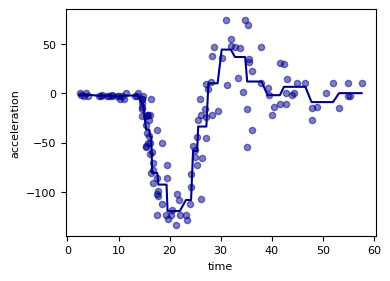

In [107]:
# We start by fitting a CART to the model
y = df['acceleration'] 
X = df['time'].values.reshape(-1,1)

cart = tree.DecisionTreeRegressor(min_samples_leaf = 5) # can experiment with parameters 
cart = cart.fit(X, y)

y_pred = cart.predict(X)

df.plot.scatter(x = 'time', y = 'acceleration',c = 'DarkBlue', alpha = 0.5)
plt.plot(X, y_pred, c = 'DarkBlue')


In [108]:
# now, let's fit a random forest
# note, here we might need to add some stopping rule for our individual trees. Otherwise, random forest looks like it 
# overfits. 
# At the same time, your stopping rule should not be very strict. 
# How can you check: in real applications always have a training and a test datasets, so that you could train different 
# models (e.g. using different stopping rules) and check their out-of-sample performance on the test data. Alternatively tune your model with CV. 

y = df['acceleration'] 
X = df['time'].values.reshape(-1,1)

rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 5, oob_score = True, \
        random_state = 1)
# n_estimators - the number of trees in the forest 
# oob_score - whether to use out-of-bag samples to estimate the generalization score

rf = rf.fit(X, y)

ypred_rf = rf.predict(X)

#you can see on the graph below that by growing full trees, our random forest estimator looks too noisy. (likely because we have a small number of observations)
#try changing the stopping rule

OOB Score: 0.736


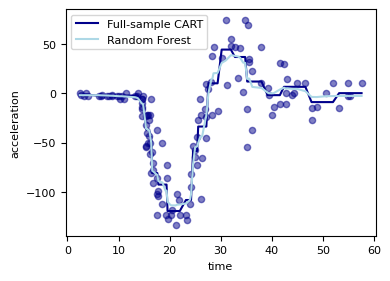

In [109]:
df.plot.scatter(x = 'time', y = 'acceleration',c = 'DarkBlue', alpha = 0.5)
plt.plot(X, y_pred, c = 'DarkBlue', label = 'Full-sample CART')
plt.plot(X, ypred_rf, c = 'LightBlue', label="Random Forest")
plt.legend()

# OOB-score as an estimate for out of sample performance 
print('OOB Score: %.3f'
      % rf.oob_score_)


In [110]:
# Use cross-validation to determine the optimal number of trees
# I already added a stopping rule of min_samples_leaf = 3. 

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 3, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error', cv = kf) # to show an alternative way to get the score with cross_validate; you could do the same with cross_val_score as above.
    #neg_mean_squared_error 
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

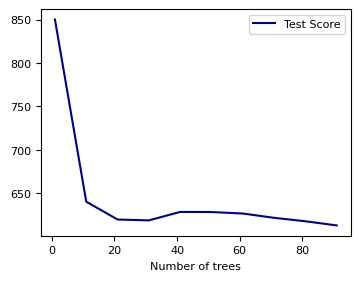

In [111]:
# note: it takes some time to run 
y = df['acceleration'] 
X = df['time'].values.reshape(-1,1)

result = {}
for i in range(1, 100, 10):
    result[i] = cv_iter(i, 10, X, y)

matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# On this graph we could also see how a random forest helps to reduce the MSE (our proxy for a single decision tree 
# is n_estimators = 1) 

# Conclusion

* Trees and forests are good tools when we expect to have non-linearities and interactions in our data + when we are agnostic about the data generation process
* Flexibility of the approach also makes the predictions less stable, highly variable: 
    * Stopping rules 
    * Pruning techniques - use CV to select a tree with a smaller number of terminal nodes
    * Bagging / Random forests - average over simple CART trees 
* There are other tree-based algorithms 
    * Boosted trees
    * Bayes Additive trees
    * Dynamic trees 
* Trees perform well when the number of parameters relative to $N$ is not very high and when observations are independent 
    * Otherwise, alternative techniques or additional data transformations

# Questions

Please, let me know if there are any questions or suggestions regarding these slides. 

        #tutorial-6-cart on slack or by email

# Resources 

Matt Taddy (2019) Business Data Science: Combining Machine Learning and Economics to Optimize, Automate, and Accelerate Business Decisions. McGraw-Hill Education

James/Witten/Hastie/Tibrashini (2021) Introduction to Statistical Learning  https://web.stanford.edu/~hastie/ISLR2/ISLRv2_website.pdf